# Comparison Cost-sensitive ML models

In [1]:
from collections import Counter
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate)
from src.utils import (print_training_results, plot_roc_cm, AUROC_model_comparison)

In [2]:
#  Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input Data
The input data can be found, and download here: [zenodo link](https://zenodo.org/records/10251230)

In [3]:
df = pd.read_csv("../data/data_143_features.csv")
print(df.shape)
df.head()

(50847, 144)


,log2_fpkm,near_fantom_enhancer,near_cancer_associated_snp,number_of_exons,within_pol2_loop,near_hnisz_super_enhancer,within_ctcf_loop,near_hnisz_enhancer,has_mouse_ortholog,locus_is_heterozygous_deleted,is_intergenic,transcript_length,locus_is_amplified,is_antisense,locus_locus_distance,tss_pc_distance,near_vista_enhancer,locus_is_homozygous_deleted,ARID3A,ATF1,ATF2,ATF3,BACH1,BCLAF1,BHLHE40,BRCA1,CBX3,CBX8,CEBPB,CEBPZ,CHD1,CHD2,CHD7,CREB1,CTBP2,CTCF,CTCFL,CUX1,E2F1,E2F4,E2F6,EGR1,ELF1,ELK1,EP300,ESRRA,ETS1,EZH2,FOS,FOSL1,FOSL2,FOXA1,FOXM1,GABPA,GATA1,GATA2,GATA3,GTF2F1,HCFC1,HDAC1,HDAC2,HDAC6,HSF1,IKZF1,IRF1,JUN,JUND,KDM1A,KDM5A,KDM5B,MAFF,MAFK,MAX,MAZ,MEF2A,MTA3,MXI1,MYBL2,MYC,NANOG,NCOR1,NFE2,NFIC,NFYA,NFYB,NR2C2,NR2F2,NR3C1,NRF1,PHF8,PML,POLR2A,POU5F1,RAD21,RBBP5,RCOR1,RELA,REST,RFX5,RNF2,RXRA,SAP30,SETDB1,SIN3A,SIX5,SMARCA4,SMARCB1,SMARCC2,SMC3,SP1,SPI1,SREBF1,SREBF2,SRF,STAT5A,SUPT20H,SUZ12,TAF1,TAF7,TAL1,TBL1XR1,TBP,TCF12,TCF7L2,TEAD4,THAP1,TRIM28,UBTF,USF1,USF2,YY1,ZBTB33,ZBTB7A,ZC3H11A,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3,number_tfs,hit
0,2.9612,0,0,2.5000,0,0,0,0,0,0,1,"3,019.5000",0,0,43833,48473,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
1,-0.1795,0,0,2.0000,0,0,0,0,0,0,1,609.0000,0,0,42685,44966,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
2,-1.3535,0,1,2.0000,0,0,0,0,1,0,1,582.0000,0,0,0,22062,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
3,-1.0786,0,0,4.0000,0,0,0,0,0,0,1,639.0000,0,0,0,7516,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000

## 2) ML model configs

In [4]:
with open("config_files/config_cost_sensitive_clfs.yaml", "r") as file:
    config = yaml.safe_load(file)

# ML configs
SEED = config["SEED"]["seed"]
xgboost_configs = config["xgboost"]
balanced_rf_configs = config["balanced_rf"]

### 2.1) Train/Test split

In [5]:
X = df.drop(columns=["hit"]).copy(deep=True)
print(X.shape)
X.head()

(50847, 143)


,log2_fpkm,near_fantom_enhancer,near_cancer_associated_snp,number_of_exons,within_pol2_loop,near_hnisz_super_enhancer,within_ctcf_loop,near_hnisz_enhancer,has_mouse_ortholog,locus_is_heterozygous_deleted,is_intergenic,transcript_length,locus_is_amplified,is_antisense,locus_locus_distance,tss_pc_distance,near_vista_enhancer,locus_is_homozygous_deleted,ARID3A,ATF1,ATF2,ATF3,BACH1,BCLAF1,BHLHE40,BRCA1,CBX3,CBX8,CEBPB,CEBPZ,CHD1,CHD2,CHD7,CREB1,CTBP2,CTCF,CTCFL,CUX1,E2F1,E2F4,E2F6,EGR1,ELF1,ELK1,EP300,ESRRA,ETS1,EZH2,FOS,FOSL1,FOSL2,FOXA1,FOXM1,GABPA,GATA1,GATA2,GATA3,GTF2F1,HCFC1,HDAC1,HDAC2,HDAC6,HSF1,IKZF1,IRF1,JUN,JUND,KDM1A,KDM5A,KDM5B,MAFF,MAFK,MAX,MAZ,MEF2A,MTA3,MXI1,MYBL2,MYC,NANOG,NCOR1,NFE2,NFIC,NFYA,NFYB,NR2C2,NR2F2,NR3C1,NRF1,PHF8,PML,POLR2A,POU5F1,RAD21,RBBP5,RCOR1,RELA,REST,RFX5,RNF2,RXRA,SAP30,SETDB1,SIN3A,SIX5,SMARCA4,SMARCB1,SMARCC2,SMC3,SP1,SPI1,SREBF1,SREBF2,SRF,STAT5A,SUPT20H,SUZ12,TAF1,TAF7,TAL1,TBL1XR1,TBP,TCF12,TCF7L2,TEAD4,THAP1,TRIM28,UBTF,USF1,USF2,YY1,ZBTB33,ZBTB7A,ZC3H11A,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3,number_tfs
0,2.9612,0,0,2.5000,0,0,0,0,0,0,1,"3,019.5000",0,0,43833,48473,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
1,-0.1795,0,0,2.0000,0,0,0,0,0,0,1,609.0000,0,0,42685,44966,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
2,-1.3535,0,1,2.0000,0,0,0,0,1,0,1,582.0000,0,0,0,22062,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
3,-1.0786,0,0,4.0000,0,0,0,0,0,0,1,639.0000,0,0,0,7516,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0

In [6]:
nan_features = X.isna().sum().reset_index().rename(columns={"index": "features", 0: "is_na"})
nan_features[nan_features["is_na"] == 1]

,features,is_na


In [7]:
y = df[['hit']].astype('int64').copy(deep=True)
num_classses = Counter(y.values.ravel())
print(num_classses)
y.head()

Counter({0: 49936, 1: 911})


,hit
0,0
1,0
2,0
3,0
4,0


## 3) ML training

In [8]:
# CV:
stratified_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state= SEED)

# scoring:
scoring = {"sensitivity": "recall", 
           "f1_score": "f1", 
           "precision": "precision",
           "auroc": "roc_auc",  
           "brier score": "neg_brier_score"}

### 3.1) Cost-sensitive XGBoost

In [9]:
%%time

# XGBoost training
xgboost_model = xgb.XGBClassifier(**xgboost_configs)
xgboost_cv_results = cross_validate(xgboost_model, 
                                 X, 
                                 y.values.ravel(), 
                                 cv= stratified_cv, 
                                 scoring= list(scoring.values()), 
                                 return_train_score= False, 
                                 verbose=0)

# Print results
print_training_results(scoring_dict=scoring, input_model=xgboost_model, cv_results=xgboost_cv_results)

----------
XGBClassifier mean-sensitivity: 0.7244 (+/-  0.04)
XGBClassifier mean-f1_score: 0.1264 (+/-  0.01)
XGBClassifier mean-precision: 0.0693 (+/-  0.00)
XGBClassifier mean-auroc: 0.8239 (+/-  0.02)
XGBClassifier mean-brier score: -0.1638 (+/-  0.00)
----------
CPU times: user 46.4 s, sys: 912 ms, total: 47.4 s
Wall time: 27.4 s


30it [00:26,  1.11it/s]


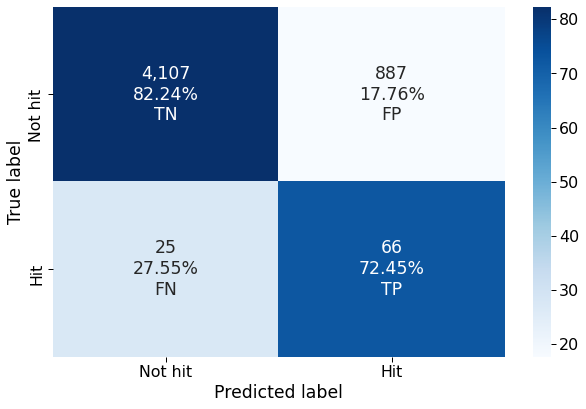

In [10]:
# Plot confussion matrix
plot_roc_cm(model= xgboost_model, cv=stratified_cv, X=X, y=y)

### 3.2) Balanced random-forest

In [11]:
%%time

# Balanced random-forest training
b_rf = BalancedRandomForestClassifier(**balanced_rf_configs)
rf_cv_results = cross_validate(b_rf, 
                               X, 
                               y.values.ravel(), 
                               cv= stratified_cv, 
                               scoring= list(scoring.values()), 
                               return_train_score= False, 
                               verbose=0)

# Print results
print_training_results(scoring_dict=scoring, input_model=b_rf, cv_results=rf_cv_results)

----------
BalancedRandomForestClassifier mean-sensitivity: 0.7603 (+/-  0.04)
BalancedRandomForestClassifier mean-f1_score: 0.1240 (+/-  0.01)
BalancedRandomForestClassifier mean-precision: 0.0675 (+/-  0.00)
BalancedRandomForestClassifier mean-auroc: 0.8438 (+/-  0.02)
BalancedRandomForestClassifier mean-brier score: -0.1460 (+/-  0.00)
----------
CPU times: user 37.2 s, sys: 1.2 s, total: 38.4 s
Wall time: 38.3 s


30it [00:35,  1.19s/it]


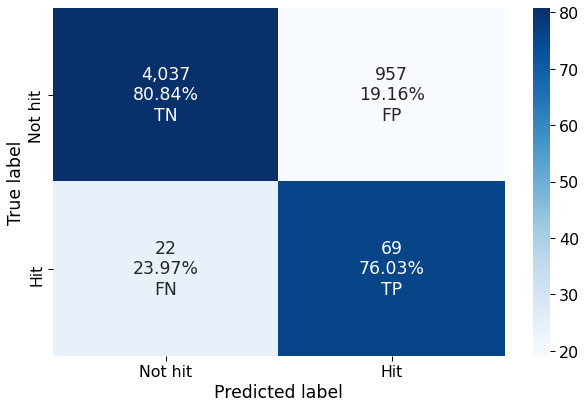

In [12]:
# Plot confussion matrix
plot_roc_cm(model= b_rf, cv=stratified_cv, X=X, y=y)

## 4) Model comparisons

XGBoost


30it [00:27,  1.10it/s]


Balanced random forest


30it [00:38,  1.28s/it]


Logistic regression


30it [06:48, 13.60s/it]


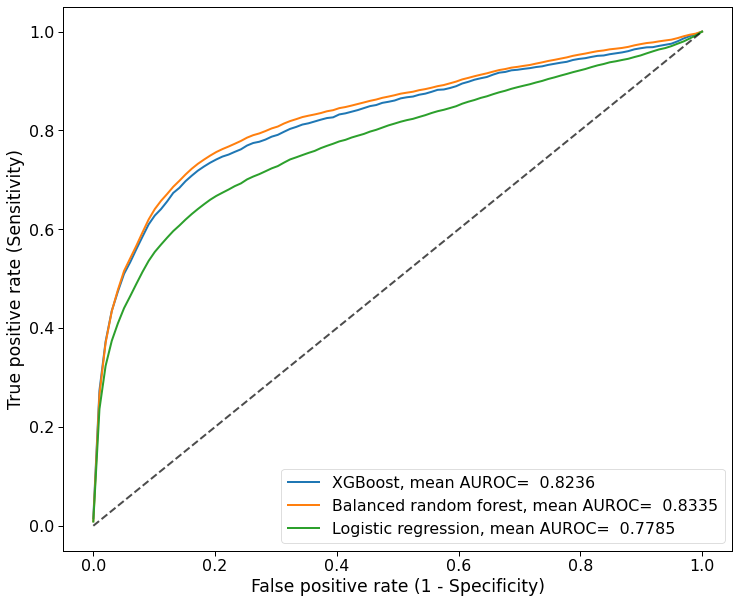

CPU times: user 8min 13s, sys: 29 s, total: 8min 42s
Wall time: 7min 53s


In [13]:
%%time

models_input = [
    {"label": "XGBoost",
    "model": xgboost_model},
    {"label": "Balanced random forest",
    "model": b_rf},
    {"label": "Logistic regression",
    "model": LogisticRegression(random_state=SEED, solver='liblinear', max_iter= 10000)}
]

AUROC_model_comparison(models_inputs= models_input, X= X, y=y, cv= stratified_cv)